Transfer Learning : Feature Extraction
     Leveraging a working models existing architecture for our own problem

In [42]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
DATASET_SOURCE = "/home/arun/learn/tensorflow_certification/datasets/food_101/mini/"
CATEGORY = ["train", "test"]


for i in CATEGORY:
    for food_class in os.listdir(os.path.join(DATASET_SOURCE, i)):
        print(f"{food_class} --> {len(os.listdir(os.path.join(DATASET_SOURCE,i, food_class)))}")

tacos --> 750
ice_cream --> 750
spring_rolls --> 750
sushi --> 750
ramen --> 750
oysters --> 750
hot_dog --> 750
nachos --> 750
samosa --> 750
fried_rice --> 750
hamburger --> 750
donuts --> 750
pizza --> 750
omelette --> 750
onion_rings --> 750
steak --> 750
tacos --> 250
ice_cream --> 250
spring_rolls --> 250
sushi --> 250
ramen --> 250
oysters --> 250
hot_dog --> 250
nachos --> 250
samosa --> 250
fried_rice --> 250
hamburger --> 250
donuts --> 250
pizza --> 250
omelette --> 250
onion_rings --> 250
steak --> 250


In [44]:
tf.random.set_seed(42)

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = os.path.join(DATASET_SOURCE, CATEGORY[0])
test_dir = os.path.join(DATASET_SOURCE, CATEGORY[1])

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")
valid_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 12000 images belonging to 16 classes.
Found 4000 images belonging to 16 classes.


In [45]:
def create_tensorboard_callback(experiment_name, model_name):
    log_dir = os.path.join("model_logs", str(experiment_name),
                           str(model_name), dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"[create_tensorboard_callback] The log dir for tensorboard is : {log_dir}")
    return tensorboard_callback

In [37]:
# Tensorflow Hub : 
# efficient b0 feature vector : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1
# resnet v2 50 feature vector : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [38]:
resnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
efficient_net_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [39]:
def create_model_from_url(model_url: str, num_classes: int, model_name="sample"):
    """
     Creates a sequential model from the given url
     returns a uncompiled model
    """
    feature_extractor_layer = hub.KerasLayer(model_url, trainable=False,
                                             name="feature_extractor_layer",
                                             input_shape=(224,224,3))
    model = tf.keras.Sequential(layers=[
        feature_extractor_layer,
        tf.keras.layers.Dense(units=int(num_classes), activation="softmax", name="output_layer")
    ], name=model_name)
    return model

In [30]:
resnet_model = create_model_from_url(resnet_url, 16, "resnet_food_classifier")

2022-01-20 17:28:06.579853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 17:28:06.587647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 17:28:06.588084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 17:28:06.588979: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [31]:
resnet_model.summary()

Model: "resnet_food_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 16)                20496     
                                                                 
Total params: 4,070,060
Trainable params: 20,496
Non-trainable params: 4,049,564
_________________________________________________________________


In [40]:
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  callbacks=[create_tensorboard_callback("food_classifier", "resnet_food_classifier")],
                                  validation_data=valid_data,
                                  steps_per_epoch=len(train_data),
                                  validation_steps=len(valid_data))

[create_tensorboard_callback] The log dir for tensorboard is : model_logs/food_classifier/resnet_food_classifier/20220120-173332
Epoch 1/5


2022-01-20 17:33:41.008857: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


375/375 [==============================] - 78s 175ms/step - loss: 0.9302 - accuracy: 0.7616 - val_loss: 0.4720 - val_accuracy: 0.8668
Epoch 2/5
375/375 [==============================] - 64s 172ms/step - loss: 0.5210 - accuracy: 0.8505 - val_loss: 0.3965 - val_accuracy: 0.8777
Epoch 3/5
375/375 [==============================] - 65s 173ms/step - loss: 0.4336 - accuracy: 0.8785 - val_loss: 0.3668 - val_accuracy: 0.8867
Epoch 4/5
375/375 [==============================] - 65s 173ms/step - loss: 0.3802 - accuracy: 0.8923 - val_loss: 0.3520 - val_accuracy: 0.8878
Epoch 5/5
375/375 [==============================] - 65s 172ms/step - loss: 0.3415 - accuracy: 0.9042 - val_loss: 0.3379 - val_accuracy: 0.8925


Text(0.5, 0, 'epochs')

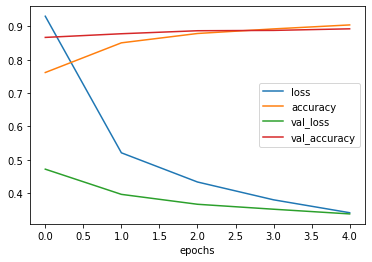

In [46]:
pd.DataFrame(resnet_history.history).plot()
plt.xlabel("epochs")

In [55]:
# Efficient net model
efficient_net_model = create_model_from_url(efficient_net_url, 16, "efficent_net_food_classifier")

In [58]:
efficient_net_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                            optimizer=tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])
efficient_net_model.summary()

Model: "efficent_net_food_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 16)                32784     
                                                                 
Total params: 23,597,584
Trainable params: 32,784
Non-trainable params: 23,564,800
_________________________________________________________________


In [60]:
efficient_net_history = efficient_net_model.fit(train_data,
                                               epochs=5,
                                               callbacks=[create_tensorboard_callback("food_classifier", "efficientNet_food_classifier")],
                                               validation_data=valid_data,
                                               steps_per_epoch=len(train_data),
                                               validation_steps=len(valid_data))

[create_tensorboard_callback] The log dir for tensorboard is : model_logs/food_classifier/efficientNet_food_classifier/20220120-174815
Epoch 1/5


2022-01-20 17:48:20.099672: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-20 17:48:20.099760: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-20 17:48:20.161242: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-20 17:48:20.161330: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

375/375 [==============================] - 96s 242ms/step - loss: 1.0758 - accuracy: 0.6788 - val_loss: 0.6593 - val_accuracy: 0.7950
Epoch 2/5
375/375 [==============================] - 89s 238ms/step - loss: 0.6712 - accuracy: 0.7987 - val_loss: 0.6085 - val_accuracy: 0.8163
Epoch 3/5
375/375 [==============================] - 87s 231ms/step - loss: 0.5455 - accuracy: 0.8317 - val_loss: 0.5999 - val_accuracy: 0.8207
Epoch 4/5
375/375 [==============================] - 78s 209ms/step - loss: 0.4690 - accuracy: 0.8547 - val_loss: 0.6101 - val_accuracy: 0.8112
Epoch 5/5
375/375 [==============================] - 81s 216ms/step - loss: 0.4064 - accuracy: 0.8784 - val_loss: 0.6080 - val_accuracy: 0.8138


Text(0.5, 0, 'epochs')

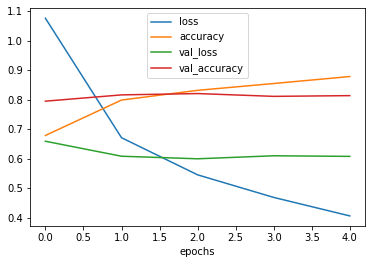

In [61]:
pd.DataFrame(efficient_net_history.history).plot()
plt.xlabel("epochs")

# Fine tuning

In [73]:
MINI_DATASET_SOURCE = '/home/arun/learn/tensorflow_certification/datasets/food_101/mini_10/'
train_dir = os.path.join(MINI_DATASET_SOURCE, "train")
test_dir = os.path.join(MINI_DATASET_SOURCE, "test")

In [74]:
print(test_dir)
print(test_dir)

/home/arun/learn/tensorflow_certification/datasets/food_101/mini_10/test
/home/arun/learn/tensorflow_certification/datasets/food_101/mini_10/test


In [75]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                               image_size=(224,224),
                                                               label_mode="categorical",
                                                               batch_size=32
                                                              )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=(224,224),
                                                                label_mode="categorical",
                                                                batch_size=32)

Found 1200 files belonging to 16 classes.
Found 4000 files belonging to 16 classes.


In [76]:
train_data.class_names

['donuts',
 'fried_rice',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'nachos',
 'omelette',
 'onion_rings',
 'oysters',
 'pizza',
 'ramen',
 'samosa',
 'spring_rolls',
 'steak',
 'sushi',
 'tacos']

In [ ]:
# model being built via functional

